# Conditional IC generation

In [4]:
import cosmax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax

In [25]:
# load image with matplotlib
img = plt.imread('../data/cosmax.png')
img = jnp.array(img)[..., 0:1]
img = jnp.moveaxis(img, 2, 0)

print(img.shape)



(1, 64, 64)


In [40]:
N = 64
MPC_h = 50

img = jnp.broadcast_to(img, (N, N, N))

img = img - jnp.mean(img)


power_spectrum = cosmax.spectral_ops.PowerSpectrum(N, MPC_h, N)

# Lets generate a power spectrum from a power law
Pk_desired = power_spectrum.k**(-3)

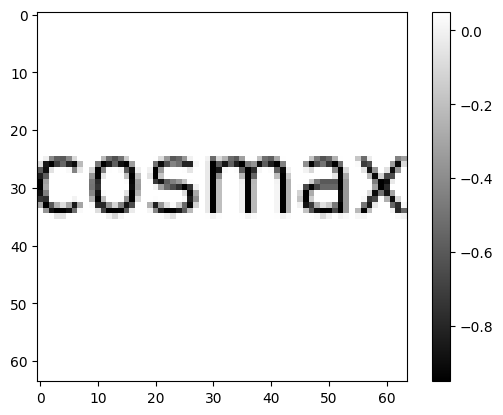

In [41]:
plt.figure()

plt.imshow(img[N // 2], cmap='gray')
plt.colorbar()



In [57]:
def mse(x, y):
    return jnp.mean((x - y)**2)

def loss(
    field : jax.Array) -> jax.Array:

    # Compute the power spectrum of the field
    k, Pk = power_spectrum(field)

    loss_ps = mse(jnp.log(Pk), jnp.log(Pk_desired))

    loss_img = mse(field, img)

    return 0.1*loss_ps + loss_img


In [58]:
import optax

opt = optax.adam(0.003)

field = jax.random.normal(jax.random.PRNGKey(0), (N, N, N))

opt_state = opt.init(field)

@jax.jit
def step(
    field : jax.Array,
    opt_state : optax.OptState) -> jax.Array:

    grad = jax.grad(loss)(field)

    updates, opt_state = opt.update(grad, opt_state)

    field = optax.apply_updates(field, updates)

    return field, opt_state

for i in range(3000):
    field, opt_state = step(field, opt_state)

    if i % 100 == 0:
        print(loss(field))

2.2444456
1.7213521
1.5104396
1.3417561
1.1792638
1.01575
0.86194706
0.71677685
0.58369946
0.4636479
0.35978296
0.27303085
0.20475775
0.15533575
0.12294615
0.10396238
0.0933111
0.08646348
0.08101005
0.076179445
0.07181057
0.06787363
0.064350106
0.061215304
0.05843942
0.055990126
0.053834565
0.051940918
0.050279297
0.04882226


Text(0.5, 1.0, '$\\rho$')

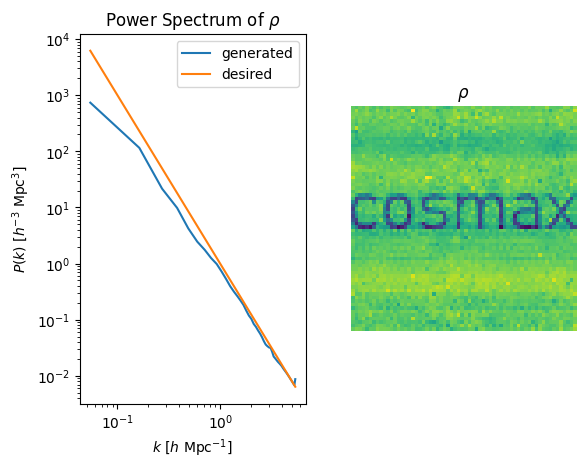

In [59]:

k_gen, Pk_gen = power_spectrum(field)

axs, fig = plt.subplots(1, 2)

fig[0].plot(k_gen, Pk_gen, label='generated')
fig[0].plot(k_gen, Pk_desired, label='desired')
fig[0].set_title(r'Power Spectrum of $\rho$')
fig[0].set_xlabel(r'$k$ [$h \ \mathrm{Mpc}^{-1}$]')
fig[0].set_ylabel(r'$P(k)$ [$h^{-3} \ \mathrm{Mpc}^3$]')
fig[0].set_xscale('log')
fig[0].set_yscale('log')
fig[0].legend()

fig[1].imshow(field[N//2])
# remove axis
fig[1].axis('off')
fig[1].set_title(r'$\rho$')

